In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch.autograd as autograd   

import torch
import pandas as pd

from scipy.interpolate import LinearNDInterpolator
device1 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')


import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import matplotlib.colors

import sys
import os

# Add the path to the directory where Seq_Model_Parallel is located
module_path = os.path.abspath('/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/')
if module_path not in sys.path:
    sys.path.append(module_path)

print("Device 1: ",device1)
print("Device 2: ",device2)

Device 1:  cuda:2
Device 2:  cuda:3


In [2]:
folder_main = '/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/Models_Trained/'
filename = 'AFSD_Exp_300rpm_2mms.pt'
data_filename = 'Exponential_300_2mms.mat'

R0 = 5.36 #mm 5.36
Rs = 19 #mm
mu_vis = 0.3 
mu = 0.3 #Friction Coefficient (not viscosity)
delta = 0.5
A = 6.41 #For slip factor
pi = np.pi
Omega = 300 #rpm
V = 2 #mm/s
F = 0.67 #mm/s
rho = 2700 * 1e-6 #g/mm3
k_B = 1.380649*1e-23 #J/K
R = 8.314 #J/(K.mol)
E_a = 205000 #J/mol #Q
alpha_sig =  52 #mm^2.ms^2/(g.mm)
# A = np.exp(27.78)
log_A = 27.78 - 6.9078 # Units in ms-1
n = 3.49
k = 167 *1e-3 #Thermal Conductivity #mW/(mmK)
c_p = 897 *1e-3 # mm^2/ms^3.K #Wrong mJ/gK 
alpha_m = k/(rho*c_p)
T_a = 298.0


k_t = 17.6 *1e-3 #gmm/(ms^3.K)
c_p_t = 460 *1e-3 # mm^2/ms^3.K
rho_t = 7750 * 1e-6 #g/mm3
alpha_t = k_t/(rho_t*c_p_t)

h_sides = 5*1e-6 #Wrong W/mm^2K #Corrected g/ms^3.K 
C_bot = 0.15*1e-6 #W/mm^2K^3 #corrected g/ms^3.K^3

eeta = alpha_m/(alpha_m+alpha_t)

lb_xyz_uvw = np.array([-50.0,-20.0,-3.0])
ub_xyz_uvw = np.array([50.0,20.0,0.0])


lb_xyz = np.array([-50.0,-20.0,-3.0])
ub_xyz = np.array([50.0,20.0,0.0])






In [3]:
from Seq_Model_Parallel import coupled_PINN

layers1 = np.array([3,50,50,50,4]) #9 hidden layers
layers2 = np.array([3,50,50,50,1]) #9 hidden layers
# layers = np.array([3,50,50,50,5])
# layers = np.array([3,64,64,64,1])
model_PINN = coupled_PINN(layers1,layers2,device1,device2,lb_xyz,ub_xyz)

model_PINN.load_state_dict(torch.load(folder_main + filename))

#Testing with FVM data
fvm_data = loadmat('/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/Data/AFSD_Nikhil/' + data_filename)

u_fvm = fvm_data['u_star']
v_fvm = fvm_data['v_star']
w_fvm = fvm_data['w_star']

u_fvm = (u_fvm[0:-1,:,:] + u_fvm[1:,:,:])/2
v_fvm = (v_fvm[:,0:-1,:] + v_fvm[:,1:,:])/2
w_fvm = (w_fvm[:,:,0:-1] + w_fvm[:,:,1:])/2


Res_v_fvm = np.sqrt(np.square(u_fvm) + np.square(v_fvm) + np.square(w_fvm))
T_fvm = fvm_data['T']
sigma_e_fvm = fvm_data['effectivestress']
eps_e_fvm = fvm_data['effstrrate']
mu_vis_fvm = fvm_data['mu']

Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=4, bias=True)
  )
)
Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)


/home/smartlab/anaconda3/envs/raghav/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz

# x_min = -20.0
# x_max = 20.0

# x = np.linspace(x_min,x_max,250)
x = np.linspace(x_min,x_max,251)
x = (x[0:-1] + x[1:]).reshape(-1,1)/2
y = np.linspace(y_min,y_max,101)
y = (y[0:-1] + y[1:]).reshape(-1,1)/2
z = np.linspace(z_min,z_max,13)
z = (z[0:-1] + z[1:]).reshape(-1,1)/2

X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device1)

# uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()

# Res_v_PINN = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))

In [5]:
g = xyz_test_tensor.clone()
g.requires_grad = True

out_uvw = model_PINN.PINN_uvw.forward(g)
        
u = out_uvw[:,0:1]
v = out_uvw[:,1:2]
w = out_uvw[:,2:3]
# p = out_uvw[:,3:4]

u_xyz = autograd.grad(u,g,torch.ones([g.shape[0], 1]).to(device1), retain_graph=True, create_graph=True,allow_unused = True)[0]
v_xyz = autograd.grad(v,g,torch.ones([g.shape[0], 1]).to(device1), retain_graph=True, create_graph=True,allow_unused = True)[0]
w_xyz = autograd.grad(w,g,torch.ones([g.shape[0], 1]).to(device1), retain_graph=True, create_graph=True,allow_unused = True)[0]


T = model_PINN.PINN_T.forward(g.to(device2)).to(device1)
sigma_e,eps_e = model_PINN.helper_sigma_eff(u_xyz,v_xyz, w_xyz,T)


# sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

#____________________________#
mu_vis = sigma_e/(3*eps_e)

T = T.cpu().detach().numpy()
eps_e = eps_e.cpu().detach().numpy()
sigma_e = sigma_e.cpu().detach().numpy()
mu_vis = mu_vis.cpu().detach().numpy()


uvw = out_uvw.cpu().detach().numpy()

Res_v_PINN = np.sqrt(np.square(uvw[:,0])+np.square(uvw[:,1])+np.square(uvw[:,2]))


Temperature Max: 466.37918  Temperature Min: 414.4177


In [6]:
def RMSE(a,b):
    return np.sqrt(np.mean(np.square(a-b)))

def RE(a_true,a):
    return np.linalg.norm((a_true-a).reshape(-1,),2)/np.linalg.norm(a_true.reshape(-1,),2)

def corr(a,b):
    return np.corrcoef(a.reshape(-1,),b.reshape(-1,))[0,1]


def correct_shape(a):
    a = a.reshape(12,250,100,order = 'C')
    return np.swapaxes(np.swapaxes(a,0,1),1,2)

def print_metrics(a,b,name):
    print("---------------------"+name+"---------------------")
    print("RMSE ",RMSE(a.reshape(-1,),b.reshape(-1,)))
    print("RE ", RE(a.reshape(-1,),b.reshape(-1,)))
    print("Corr ", corr(a.reshape(-1,),b.reshape(-1,)))
    print("------------------------------------------")

#IMPORTANT - RUN THIS ONLY ONCE
T = correct_shape(T)
eps_e = correct_shape(eps_e)
sigma_e = correct_shape(sigma_e)
mu_vis = correct_shape(mu_vis)
Res_v_PINN = correct_shape(Res_v_PINN)
# mu_vis = correct_shape(mu_vis)




In [7]:
print_metrics(T_fvm,T,"T")
print_metrics(eps_e_fvm,eps_e*1000,"Eps")
print_metrics(sigma_e_fvm/1e6,sigma_e,"Sigma")
print_metrics(Res_v_fvm,Res_v_PINN/1000,"Res V")
print_metrics(mu_vis_fvm/1e9,mu_vis,"Mu Vis")

---------------------T---------------------
RMSE  134.0987579282177
RE  0.24799766634064302
Corr  0.9730273900892731
------------------------------------------
---------------------Eps---------------------
RMSE  3.0591939403285355
RE  0.5278087051923638
Corr  0.9498902622433119
------------------------------------------
---------------------Sigma---------------------
RMSE  85.70479648700028
RE  0.9981849574749191
Corr  0.6551947974989556
------------------------------------------
---------------------Res V---------------------
RMSE  0.00512417641194606
RE  0.40152932053181534
Corr  0.9631581992191172
------------------------------------------
---------------------Mu Vis---------------------
RMSE  36.562317450442386
RE  0.4466556712465714
Corr  0.7522802134858051
------------------------------------------


In [19]:
np.min(sigma_e)

0.1545612

In [12]:
#unit corrections #Run Only Once
eps_e = eps_e*1000
sigma_e_fvm = sigma_e_fvm/1e3
Res_v_PINN = Res_v_PINN/1000


Vmin: 0.0
Vmax: 0.14037896294322796


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


All plots successfully saved...!


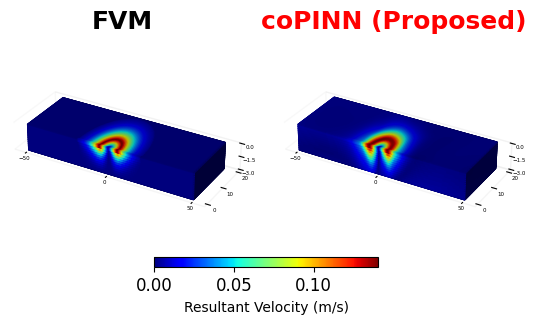

In [13]:
from Plot_helper_Oct2024 import plot3D_comp2
#For plots
lb_xyz = np.array([-50,0,-3])
ub_xyz = np.array([50,20,0])

resol_x= 250 #250
resol_y= 50 #50
resol_z = 12 #12

[x_min,y_min,z_min] = lb_xyz# THIS  IS FOR THE PLOT and NOT THE PROBLEM
[x_max,y_max,z_max] = ub_xyz

#Left Data
right_data = Res_v_PINN[:,50:,:]

#-----------------------
#Right Data
left_data = Res_v_fvm[:,50:,:]


save_name = 'Res_Velocity'
colorbar_label = "Resultant Velocity (m/s)"


plot_titles = {"left": "FVM","right": "coPINN (Proposed)"}
colormap_name = 'jet'
folder_base = '/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/Plots/'

vmin_max = None

plot_params = {"plot_titles":plot_titles,"colormap_name":colormap_name,"folder_base":folder_base,
               "save_name":save_name,"vmin_max":vmin_max,"colorbar_label":colorbar_label}



data = {"left":left_data,"right":right_data}

proposed_indicator = 'r'

data_params = {'resol_x':resol_x,'resol_y':resol_y,'resol_z':resol_z,'data':data,
               'lb_xyz':lb_xyz,"ub_xyz":ub_xyz,'proposed_indicator':proposed_indicator}


plot3D_comp2(plot_params,data_params,data)

Vmin: 298.0
Vmax: 741.9476887792522


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


All plots successfully saved...!


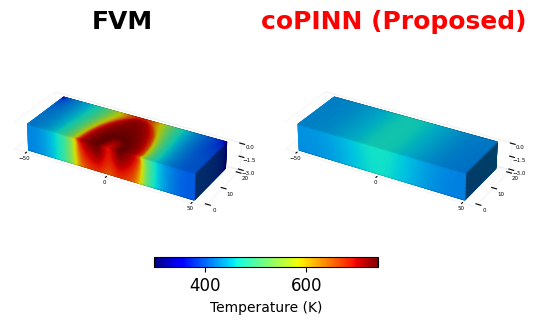

In [14]:
right_data = T[:,50:,:]

#-----------------------
#Right Data
left_data = T_fvm[:,50:,:]


save_name = 'Temperature'
colorbar_label = "Temperature (K)"


plot_titles = {"left": "FVM","right": "coPINN (Proposed)"}
colormap_name = 'jet'
folder_base = '/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/Plots/'

vmin_max = None

plot_params = {"plot_titles":plot_titles,"colormap_name":colormap_name,"folder_base":folder_base,
               "save_name":save_name,"vmin_max":vmin_max,"colorbar_label":colorbar_label}



data = {"left":left_data,"right":right_data}

proposed_indicator = 'r'

data_params = {'resol_x':resol_x,'resol_y':resol_y,'resol_z':resol_z,'data':data,
               'lb_xyz':lb_xyz,"ub_xyz":ub_xyz,'proposed_indicator':proposed_indicator}

plot3D_comp2(plot_params,data_params,data)

Vmin: 0.0
Vmax: 258.50563257971356


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


All plots successfully saved...!


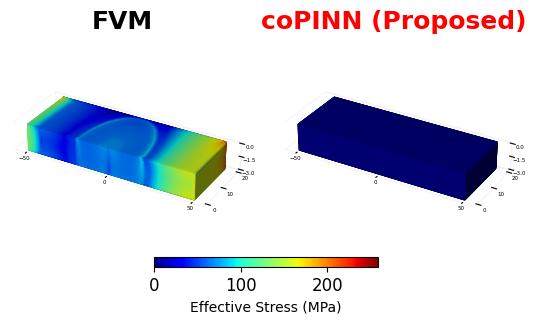

In [16]:
right_data = sigma_e[:,50:,:]

#-----------------------
#Right Data
left_data = sigma_e_fvm[:,50:,:]


save_name = 'Effective Stess'
colorbar_label = "Effective Stress (MPa)"


plot_titles = {"left": "FVM","right": "coPINN (Proposed)"}
colormap_name = 'jet'
folder_base = '/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/Plots/'

# vmin_max = {"vmin":4,"vmax":8}

plot_params = {"plot_titles":plot_titles,"colormap_name":colormap_name,"folder_base":folder_base,
               "save_name":save_name,"vmin_max":None,"colorbar_label":colorbar_label}



data = {"left":left_data,"right":right_data}

proposed_indicator = 'r'

data_params = {'resol_x':resol_x,'resol_y':resol_y,'resol_z':resol_z,'data':data,
               'lb_xyz':lb_xyz,"ub_xyz":ub_xyz,'proposed_indicator':proposed_indicator}

plot3D_comp2(plot_params,data_params,data)

In [46]:
right_data = eps_e[:,50:,:]

#-----------------------
#Right Data
left_data = eps_e_fvm[:,50:,:]


save_name = 'Effective Strain Rate'
colorbar_label = "Effective Strain Rate ($s^{-1}$)"


plot_titles = {"left": "FVM","right": "coPINN (Proposed)"}
colormap_name = 'jet'
folder_base = '/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/Plots/'

vmin_max = {"vmin":0,"vmax":200}

plot_params = {"plot_titles":plot_titles,"colormap_name":colormap_name,"folder_base":folder_base,
               "save_name":save_name,"vmin_max":vmin_max,"colorbar_label":colorbar_label}



data = {"left":left_data,"right":right_data}

proposed_indicator = 'r'

data_params = {'resol_x':resol_x,'resol_y':resol_y,'resol_z':resol_z,'data':data,
               'lb_xyz':lb_xyz,"ub_xyz":ub_xyz,'proposed_indicator':proposed_indicator}

plot3D_comp2(plot_params,data_params,data)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


All plots successfully saved...!


In [ ]:
right_data = np.log10(mu_vis[:,50:,:]*1e6)

#-----------------------
#Right Data
left_data = np.log10(mu_vis_fvm[:,50:,:])


save_name = 'Viscosity'
colorbar_label = "$log_{10}$ Viscosity"


plot_titles = {"left": "FVM","right": "coPINN (Proposed)"}
colormap_name = 'plasma'
folder_base = '/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/Plots/'

vmin_max = None

plot_params = {"plot_titles":plot_titles,"colormap_name":colormap_name,"folder_base":folder_base,
               "save_name":save_name,"vmin_max":vmin_max,"colorbar_label":colorbar_label}



data = {"left":left_data,"right":right_data}

proposed_indicator = 'r'

data_params = {'resol_x':resol_x,'resol_y':resol_y,'resol_z':resol_z,'data':data,
               'lb_xyz':lb_xyz,"ub_xyz":ub_xyz,'proposed_indicator':proposed_indicator}

plot3D_comp2(plot_params,data_params,data)

In [222]:
Res_v_fvm.shape

(250, 100, 12)

Text(0.5, 0, 'Resultant Velocity (m/s)')

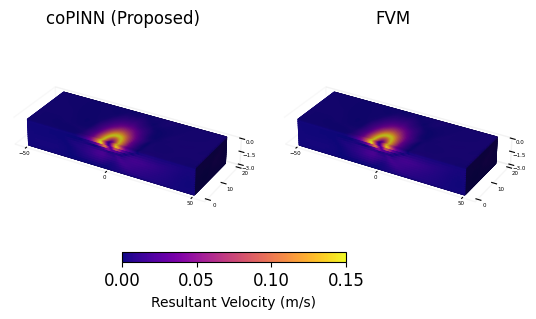

In [14]:
#Plot 3D
resol_x= 250 #250
resol_y= 50 #50
resol_z = 12 #12


x = np.linspace(x_min,x_max,resol_x+1)
x = (x[0:-1] + x[1:]).reshape(-1,1)/2
y = np.linspace(0,y_max,resol_y+1)
y = (y[0:-1] + y[1:]).reshape(-1,1)/2
z = np.linspace(z_min,z_max,resol_z+1)
z = (z[0:-1] + z[1:]).reshape(-1,1)/2

X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device1)

uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()

Res_v_PINN = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))/1000
Res_v_PINN = Res_v_PINN.reshape(resol_z,resol_x,resol_y,order = 'C')
Res_v_PINN = np.swapaxes(np.swapaxes(Res_v_PINN,0,1),1,2)
# Res_v_PINN = np.swapaxes(Res_v_PINN,0,1)

axes = [resol_x, resol_y,resol_z] # change to 64
# axes = [20,20,20]
alpha = 0.9

min_val = 0
max_val = 0.15
mid_val = 0.75

fig = plt.figure()
fig.tight_layout()
# 
# fig,ax = plt.subplots(3,1,projection='3d') 

# ax_locs  = [131,132,133]


traj = Res_v_PINN

# traj[traj<min_val] = min_val
# traj[traj>max_val] = max_val
# mid_x = np.median(traj)

normalized_traj = (traj - np.min(traj)) / (np.max(traj) - np.min(traj))

# Get the jet colormap
colormap = plt.get_cmap('plasma')

# Map normalized data to colors using the colormap
colors = colormap(normalized_traj)  # This gives RGBA colors

# colors = np.empty(axes + [4], dtype=np.float32)

# colors[:,:,:,3] = alpha
# colors[:,:,:,0] = (traj-min_val)/(max_val-min_val)
# colors[:,:,:,1] = 1.0 - (traj<mid_val)*np.abs(traj-mid_val)/(mid_val-min_val) - (traj>mid_val)*np.abs(traj-mid_val)/(max_val-mid_val)
# colors[:,:,:,2] = 1 - (traj-min_val)/(max_val-min_val)

# colors = plt.cm.jet(data)

# ax.clear()
ax = fig.add_subplot(121,projection='3d')

x = np.linspace(x_min,x_max,resol_x+1)
y = np.linspace(0,y_max,resol_y+1)
z = np.linspace(z_min,z_max,resol_z+1)

X,Y,Z = np.meshgrid(y,x,z)
vox = ax.voxels(Y,X,Z,traj,facecolors=colors,edgecolors=colors)
# ax.axis('off')
# ax.set_xlabel('$x$',fontsize = 18,math_fontfamily = 'cm')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# ax.set_zlim([-50, 50])  # Set x-axis limits
# ax.set_xlim([-50, 50])  # Set y-axis limits
# ax.set_ylim([-3, 0])  # Set z-axis limits

ax.xaxis.pane.fill = False  # Hide the background of the x-axis
ax.yaxis.pane.fill = False  # Hide the background of the y-axis
ax.zaxis.pane.fill = False  # Hide the background of the z-axis
ax.xaxis.set_ticks(np.linspace(-50,50,3))       # Hide tick marks for the x-axis
ax.yaxis.set_ticks(np.linspace(0,20,3))       # Hide tick marks for the y-axis
ax.zaxis.set_ticks(np.linspace(-3,0,3))       # Hide tick marks for the z-axis
ax.tick_params(axis='both',which='major',pad = -5, labelsize = 4)

ax.grid(False)

ax.xaxis.line.set_color((1, 1, 1, 0))  # Set x-axis line color to transparent
ax.yaxis.line.set_color((1, 1, 1, 0))  # Set y-axis line color to transparent
ax.zaxis.line.set_color((1, 1, 1, 0))  # Set z-axis line color to transparent

# Hide grid structure

ax.set_box_aspect([7.0, 2.5, 1.0])
ax.set_title('coPINN (Proposed)')

# norm = matplotlib.colors.Normalize(vmin=0, vmax=0.15)
# m = cm.ScalarMappable(cmap=colormap, norm=norm)
# m.set_array([])
# cbaxes = fig.add_axes([0.3,0.25, 0.35, 0.02])
# cbar = fig.colorbar(m,cax = cbaxes,orientation = 'horizontal', aspect = 1)
# cbar.ax.tick_params(labelsize=12,labelbottom = True,labeltop = False, bottom =True, top = False)
# cbar.ax.set_xlabel('Resultant Velocity (m/s)')

ax = fig.add_subplot(122,projection='3d')

x = np.linspace(x_min,x_max,resol_x+1)
y = np.linspace(0,y_max,resol_y+1)
z = np.linspace(z_min,z_max,resol_z+1)

X,Y,Z = np.meshgrid(y,x,z)
vox = ax.voxels(Y,X,Z,traj,facecolors=colors,edgecolors=colors)
# ax.axis('off')
# ax.set_xlabel('$x$',fontsize = 18,math_fontfamily = 'cm')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# ax.set_zlim([-50, 50])  # Set x-axis limits
# ax.set_xlim([-50, 50])  # Set y-axis limits
# ax.set_ylim([-3, 0])  # Set z-axis limits

ax.xaxis.pane.fill = False  # Hide the background of the x-axis
ax.yaxis.pane.fill = False  # Hide the background of the y-axis
ax.zaxis.pane.fill = False  # Hide the background of the z-axis
ax.xaxis.set_ticks(np.linspace(-50,50,3))       # Hide tick marks for the x-axis
ax.yaxis.set_ticks(np.linspace(0,20,3))       # Hide tick marks for the y-axis
ax.zaxis.set_ticks(np.linspace(-3,0,3))       # Hide tick marks for the z-axis
ax.tick_params(axis='both',which='major',pad = -5, labelsize = 4)

ax.grid(False)

ax.xaxis.line.set_color((1, 1, 1, 0))  # Set x-axis line color to transparent
ax.yaxis.line.set_color((1, 1, 1, 0))  # Set y-axis line color to transparent
ax.zaxis.line.set_color((1, 1, 1, 0))  # Set z-axis line color to transparent

# Hide grid structure

ax.set_box_aspect([7.0, 2.5, 1.0])
ax.set_title('FVM')

norm = matplotlib.colors.Normalize(vmin=0, vmax=0.15)
m = cm.ScalarMappable(cmap=colormap, norm=norm)
m.set_array([])
cbaxes = fig.add_axes([0.3,0.25, 0.35, 0.02])
cbar = fig.colorbar(m,cax = cbaxes,orientation = 'horizontal', aspect = 1)
cbar.ax.tick_params(labelsize=12,labelbottom = True,labeltop = False, bottom =True, top = False)
cbar.ax.set_xlabel('Resultant Velocity (m/s)')




In [215]:
a = (2)

In [216]:
a

2

In [132]:
Z.shape

(5, 25, 12)

In [107]:
x_min

-50.0

In [81]:
np.min(normalized_traj)

0.0

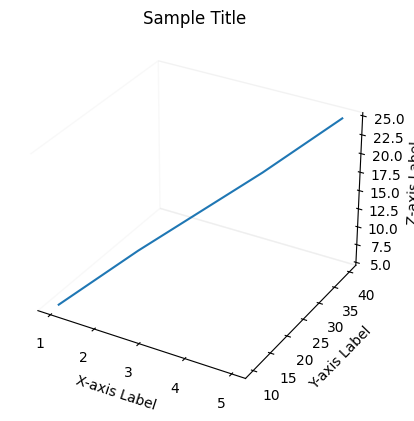

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data
x = [1, 2, 3, 4, 5]
y = [10, 20, 25, 30, 40]
z = [5, 10, 15, 20, 25]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting data
ax.plot(x, y, z)

# Adding labels
ax.set_title('Sample Title')
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_zlabel('Z-axis Label')

ax.xaxis.pane.fill = False  # Hide the background of the x-axis
ax.yaxis.pane.fill = False  # Hide the background of the y-axis
ax.zaxis.pane.fill = False  # Hide the background of the z-axis
ax.xaxis.set_tick_params(width=0)  # Hide tick marks for the x-axis
ax.yaxis.set_tick_params(width=0)  # Hide tick marks for the y-axis
ax.zaxis.set_tick_params(width=0)  # Hide tick marks for the z-axis

ax.grid(False)
# Show the plot
plt.show()


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

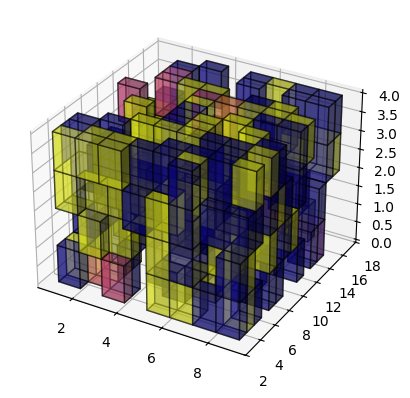

In [36]:

x,y,z = np.mgrid[1:10,3:18,0:5]
data = np.random.normal(0,10,[x.shape[0]-1,x.shape[1]-1,x.shape[2]-1])
visiblebox = np.random.choice([True,False],data.shape)

ax = plt.figure().add_subplot(111,projection ='3d')
colors = plt.cm.plasma(data)
norm = matplotlib.colors.Normalize(vmin=0, vmax=16)

vox = ax.voxels(x,y,z,visiblebox,facecolors=colors,alpha = 0.5,edgecolor='k')

m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
m.set_array([])
plt.colorbar(m)

plt.show()

In [39]:
data.shape

(8, 14, 4)

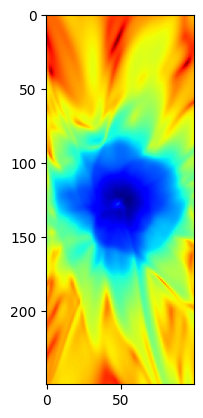

In [30]:
plt.imshow(np.log10(mu_vis[:,:,9]*1e9),cmap='jet')

In [14]:
# PLOTTING
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz

x_min = -20.0
x_max = 20.0



x = np.linspace(x_min,x_max,200).reshape(-1,1)
# y = np.linspace(y_min,y_max,200).reshape(-1,1)
y = 0.0
z = np.linspace(z_min,z_max,50).reshape(-1,1)
# z = -0.125
X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device1)

uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()

In [168]:
#Tracing Points
xyz_start = np.array([0.0,0.0,-0.01])

n_timesteps = 2000


xyz_trace = np.zeros((n_timesteps+1,3))
eps_e_trace = np.zeros((n_timesteps))

xyz_trace[0] = xyz_start 
xyz = xyz_trace[0]

for t in range(n_timesteps):
    xyz_tensor = torch.from_numpy(xyz).float().to(device1)
    uvwp = model_PINN.PINN_uvw.forward(xyz_tensor).cpu().detach().numpy()

    dx = uvwp[0]/10000.0
    dy = uvwp[1]/10000.0
    dz = uvwp[2]/10000.0
    
    xyz = xyz + np.array([dx,dy,dz])


    g = xyz_tensor.reshape(1,-1).clone()
    g.requires_grad = True

    out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
    u = out_full[:,0:1]
    v = out_full[:,1:2]
    w = out_full[:,2:3]
    p = out_full[:,3:4]


    # print(T.shape)
    T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

    # print(u.shape)
    # [ront]

    # p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
    u_xyz = autograd.grad(u,g,torch.ones([g.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
    v_xyz = autograd.grad(v,g,torch.ones([g.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
    w_xyz = autograd.grad(w,g,torch.ones([g.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

    eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
    eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
    eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

    eps2_21 = eps2_12
    eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
    eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

    eps2_31 = eps2_13
    eps2_32 = eps2_23 
    eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

    eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)

    eps_e_trace[t] = eps_e

    xyz_trace[t+1,:] = xyz

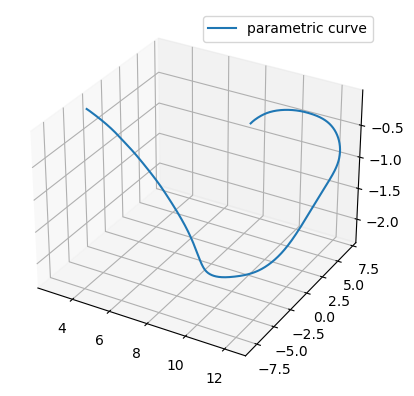

In [162]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(xyz_trace[:,0], xyz_trace[:,1], xyz_trace[:,2], label='parametric curve')
ax.legend()

plt.show()

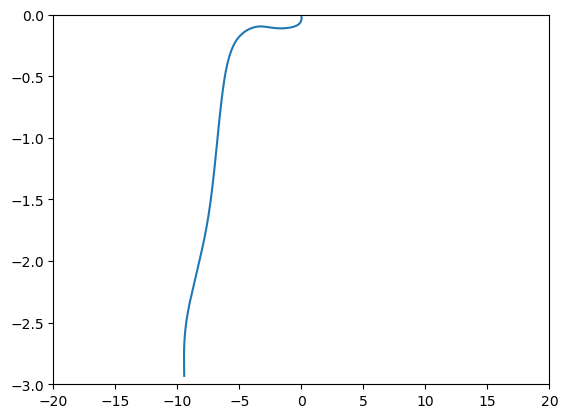

In [166]:
fig,ax = plt.subplots()
ax.plot(xyz_trace[:,0], xyz_trace[:,2], label='parametric curve')
ax.set_xlim([-20,20])
ax.set_ylim([-3.0,0.0])
# ax.set_ylim([-20,20])
# ax.legend()

plt.show()

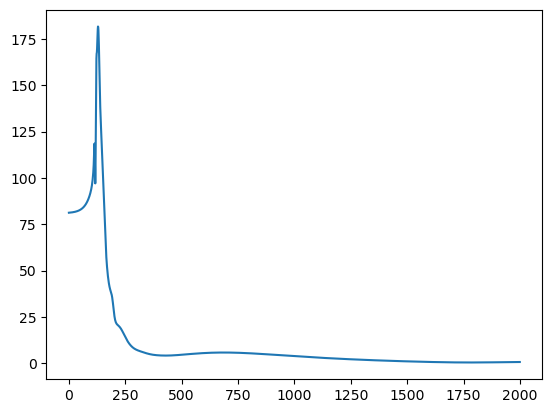

In [167]:
plt.plot(eps_e_trace)

In [154]:
z.shape

(100,)

In [155]:
# g = xyz_test_tensor.clone()
# g.requires_grad = True

# out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
# u = out_full[:,0:1]
# v = out_full[:,1:2]
# w = out_full[:,2:3]
# p = out_full[:,3:4]


# # print(T.shape)
# T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

# # p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
# u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
# v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
# w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

# eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
# eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
# eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

# eps2_21 = eps2_12
# eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
# eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

# eps2_31 = eps2_13
# eps2_32 = eps2_23 
# eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

# eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# # Z = eps_e*torch.exp(E_a/(R*T))
# # log_Z = torch.log(eps_e) + E_a/(R*T)
# log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


# W = (log_Z - log_A)/n



# # sigma_e =  (1/alpha_sig)*torch.asinh(W) 
# sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

# #____________________________#
# mu_vis = sigma_e/(3*eps_e)

# T = T.cpu().detach().numpy()
# eps_e = eps_e.cpu().detach().numpy()
# sigma_e = sigma_e.cpu().detach().numpy()
# mu_vis = mu_vis.cpu().detach().numpy()

ValueError: cannot reshape array of size 10000 into shape (200,200)

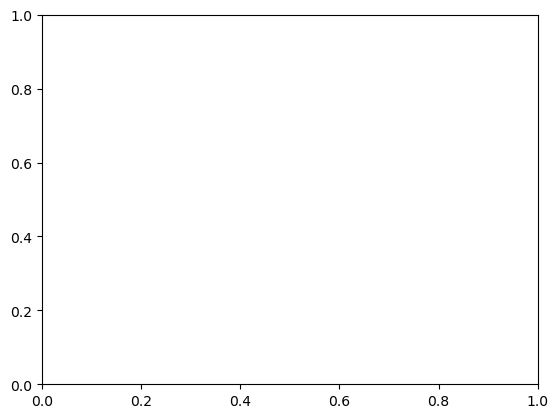

In [20]:
r_vel = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))
# r_vel = np.sqrt(np.square(uvwp[:,2]))
# r_vel = uvwp[:,2]
fig,ax = plt.subplots()
im = ax.imshow((r_vel/1000).reshape(200,200),cmap = 'jet',extent = [-20,20,-20,20],vmax = 0.15,vmin = 0)
fig.colorbar(im)
ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Res_vel_PureSlip.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$y$ (mm)')

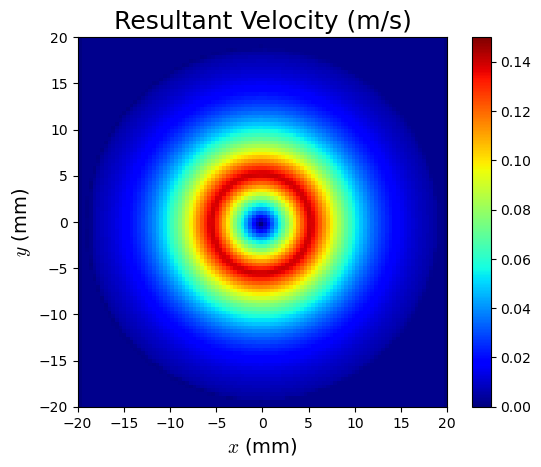

In [21]:
#FVM Plot
fig,ax = plt.subplots()
im = ax.imshow(Res_v_fvm[75:175,:,-1],cmap = 'jet',extent = [-20,20,-20,20],vmax = 0.15,vmin = 0)
fig.colorbar(im)
ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('FVM_Res_vel_Exp_xy.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

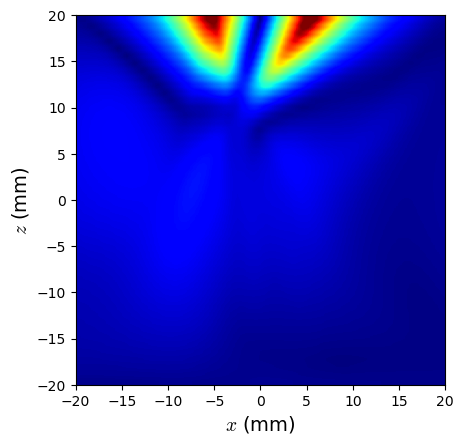

In [23]:
r_vel = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))
# r_vel = np.sqrt(np.square(uvwp[:,2]))
# r_vel = uvwp[:,2]
fig,ax = plt.subplots()
im = ax.imshow((np.flip(r_vel)/1000).reshape(50,200),cmap = 'jet',extent = [-20,20,-3,0],vmax = 0.15,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Res_vel_PureSlip_xz.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

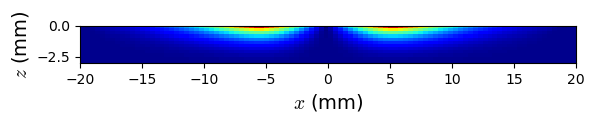

In [24]:
#FVM
fig,ax = plt.subplots()
im = ax.imshow(np.flip(np.transpose(Res_v_fvm[75:175,49,:])),cmap = 'jet',extent = [-20,20,-3,0],vmax = 0.15,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('FVM_Res_vel_Exp_xz.svg',format = 'svg',bbox_inches = 'tight')

In [25]:
g = xyz_test_tensor.clone()
g.requires_grad = True

out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
u = out_full[:,0:1]
v = out_full[:,1:2]
w = out_full[:,2:3]
p = out_full[:,3:4]


# print(T.shape)
T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

# p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

eps2_21 = eps2_12
eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

eps2_31 = eps2_13
eps2_32 = eps2_23 
eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# Z = eps_e*torch.exp(E_a/(R*T))
# log_Z = torch.log(eps_e) + E_a/(R*T)
log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


W = (log_Z - log_A)/n



# sigma_e =  (1/alpha_sig)*torch.asinh(W) 
sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

#____________________________#
mu_vis = sigma_e/(3*eps_e)


eps_e = eps_e.cpu().detach().numpy()
sigma_e = sigma_e.cpu().detach().numpy()
mu_vis = mu_vis.cpu().detach().numpy()


ValueError: cannot reshape array of size 10000 into shape (200,200)

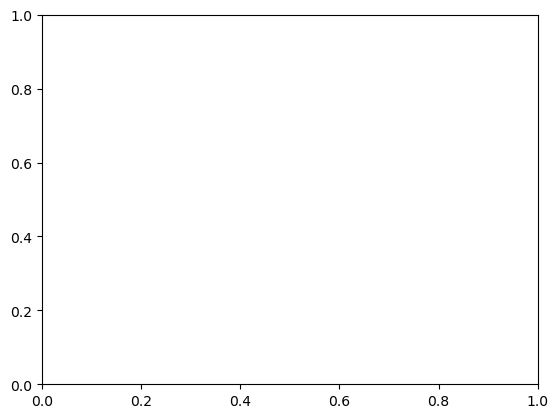

In [26]:
fig,ax = plt.subplots()
im = ax.imshow(T.cpu().detach().numpy().reshape(200,200),cmap = 'jet',extent = [-20,20,-20,20],vmax = 800,vmin = 300)
fig.colorbar(im)
ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Temp_xy_Proposal.svg',format = 'svg',bbox_inches = 't

ValueError: cannot reshape array of size 10000 into shape (200,200)

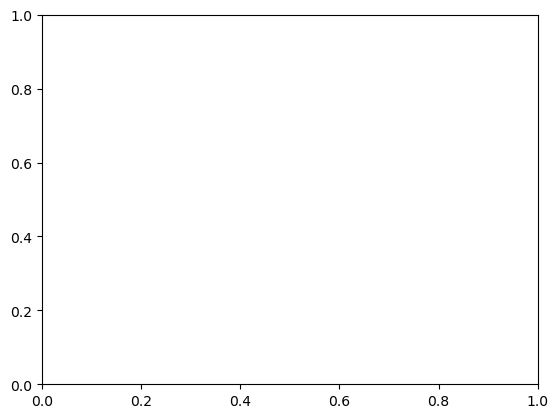

In [27]:
fig,ax = plt.subplots()
im = ax.imshow((eps_e/2).reshape(200,200),cmap = 'viridis',extent = [-20,20,-20,20],vmax = 80,vmin = 0)
fig.colorbar(im)
ax.set_title('Effective Strain Rate ($s^{-1}$)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Eps_xy_QSR.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

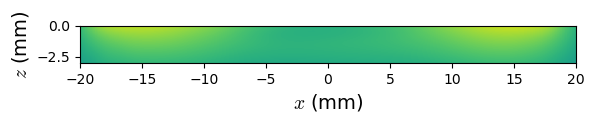

In [31]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(T.cpu().detach().numpy().reshape(50,200)),cmap = 'viridis',extent = [-20,20,-3,0],vmax = 800,vmin = 300)
# fig.colorbar(im)
# ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Eps_xz_QSR.svg',format = 'svg',bbox_inches = 'tight')

tensor([763.8500], grad_fn=<UnbindBackward0>)

In [ ]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(eps_e.cpu().detach().numpy().reshape(50,200)),cmap = 'jet',extent = [-20,20,-3,0],vmax = 800,vmin = 300)
# fig.colorbar(im)
# ax.set_title('Effective Strain Rate ($s^{-1}$)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)

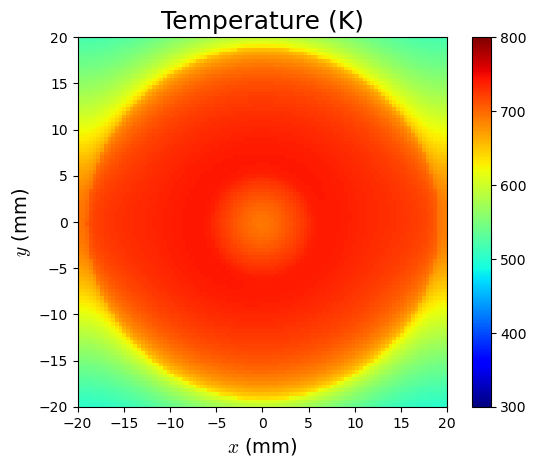

In [33]:
#FVM Plot
fig,ax = plt.subplots()
im = ax.imshow(T_fvm[75:175,:,-1],cmap = 'jet',extent = [-20,20,-20,20],vmax = 800,vmin = 300)
fig.colorbar(im)
ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_T_Exp_xy.svg',format = 'svg',bbox_inches = 'tight')

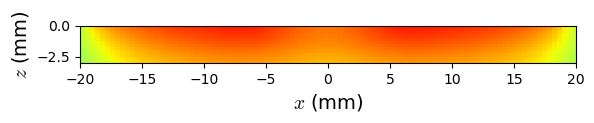

In [29]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(np.transpose(T_fvm[75:175,49,:])),cmap = 'jet',extent = [-20,20,-3,0],vmax = 800,vmin = 300)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_T_Exp_xz.svg',format = 'svg',bbox_inches = 'tight')

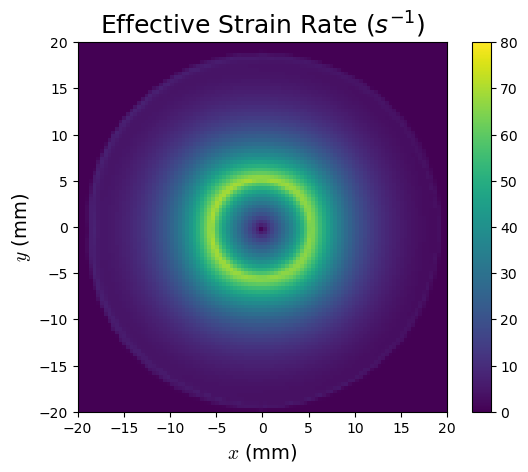

In [77]:
#FVM Plot
fig,ax = plt.subplots()
im = ax.imshow(eps_e_fvm[75:175,:,-1],cmap = 'viridis',extent = [-20,20,-20,20],vmax = 80,vmin = 0)
fig.colorbar(im)
ax.set_title('Effective Strain Rate ($s^{-1}$)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_eps_Exp_xy.svg',format = 'svg',bbox_inches = 'tight')

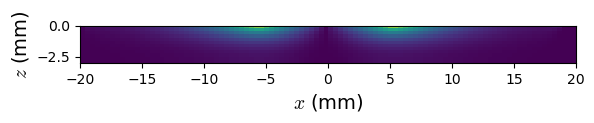

In [78]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(np.transpose(eps_e_fvm[75:175,49,:])),cmap = 'viridis',extent = [-20,20,-3,0],vmax = 80,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_eps_Exp_xz.svg',format = 'svg',bbox_inches = 'tight')